In [1]:
import torch

In [2]:
# check if GPU is available 
torch.cuda.is_available()

True

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.get_device_name()

'NVIDIA RTX A6000'

In [5]:
torch.cuda.memory_allocated()

0

In [6]:
torch.cuda.memory_reserved()

0

In [7]:
import json
root = '/home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/brain tumor data'
test_path = root+'/test/'
test_ann = root + '/test/_annotations.coco.json'
test_img_dir = test_path

In [8]:
# load annotation and get image path and labels
import os
def load_data(test_ann, test_path):
    with open(test_ann, 'r') as f:
        coco_data = json.load(f)
        
    image_id_to_label = {ann['image_id']: ann['category_id'] for ann in coco_data['annotations']}
    image_list = []
    label_list = []

    for img in coco_data['images']:
        file_name = img['file_name']
        img_id = img['id']
        label = image_id_to_label.get(img_id) # use get(img_id) is to look up the category_id(label) for the image using its ID

        if label is not None:
            image_path = os.path.join(test_path, file_name)
            image_list.append(image_path)
            label_list.append(label - 1) # convert category_id 1 and 2 to label 0 and 1
    

    print("sample image paths:", image_list[:3])
    print("Sample labels:", label_list[:3])
    return image_list , label_list

In [9]:
# SVM
# extract HOG features
import os
import json
import numpy as np
from skimage.io import imread 
from skimage.transform import resize
from skimage.feature import hog
from sklearn.svm import SVC
def extract_hog_features(test_path, img_size=(128,128)):
    features = []
    feature_length_printed = False
    for path in test_path:
        try:
            image = imread(path, as_gray=True)
            image = resize(image, img_size)
            hog_feature = hog(image, pixels_per_cell=(16,16), cells_per_block=(2,2), feature_vector=True)
            if not feature_length_printed:
                print(f"feature vector length for {path}: {len(hog_feature)}")
                feature_length_printed = True
            
            features.append(hog_feature)   
               
        except Exception as e:
            print(f"Fail to process {path}: {e}")
    
    return np.array(features)


In [10]:
# SVM + HOG
X_test_paths, y_test = load_data(test_ann, test_img_dir)
X_test_hog = extract_hog_features(X_test_paths)


sample image paths: ['/home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/brain tumor data/test/1706_jpg.rf.004b87f63425ef145855aab826e33eee.jpg', '/home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/brain tumor data/test/1363_jpg.rf.01c4537b57f360820b9e00c7e0c99ae1.jpg', '/home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/brain tumor data/test/1136_jpg.rf.02df64849485272e48139498c36c8e44.jpg']
Sample labels: [1, 1, 1]
feature vector length for /home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/brain tumor data/test/1706_jpg.rf.004b87f63425ef145855aab826e33eee.jpg: 1764


In [11]:
# load saved SVM model and prediction
import joblib
svm_model = joblib.load('/home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/base_SVM_HOG_new/best_svm_hog_model.pkl')

In [12]:
from sklearn.metrics import classification_report
y_pred_svm = svm_model.predict(X_test_hog)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       118
           1       0.90      0.91      0.90        97

    accuracy                           0.91       215
   macro avg       0.91      0.91      0.91       215
weighted avg       0.91      0.91      0.91       215



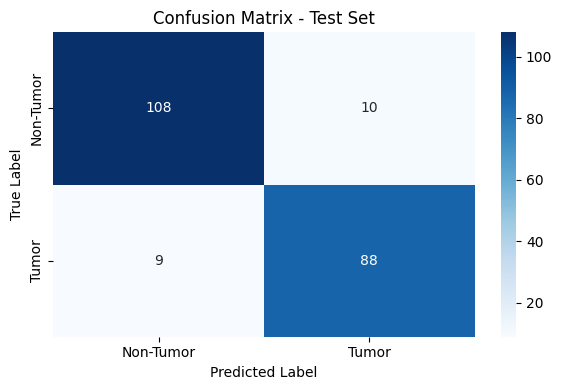

In [13]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

In [9]:
import torch
torch.cuda.empty_cache()

In [10]:
# resnet18 applied in unseen data 
import json
from torch.utils.data import Dataset
from PIL import Image

In [11]:
# load annotation and get image path and labels
class TumorDataset(Dataset):
    def __init__(self, test_ann, test_img_dir, transform=None):
        with open(test_ann, 'r') as f:
            coco_data = json.load(f)
        
        # mapping image_id to category_id
        image_id_to_label = {ann['image_id']: ann['category_id'] for ann in coco_data['annotations']}

        self.samples = []
        for img in coco_data['images']:
            file_name = img['file_name']
            img_id = img['id']
            label = image_id_to_label.get(img_id) # use get(img_id) is to look up the category_id(label) for the image using its ID

            if label is not None:
                image_path = os.path.join(test_img_dir, file_name)
                self.samples.append((image_path, label-1))
            
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [12]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models # add models to the list
from sklearn.metrics import classification_report

In [13]:
# without augmentation: just re-size and normalize
test_tranform_no_aug = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])

# with augmentation: simulate the real-world variation

test_tranform_aug = transforms.Compose([
        transforms.RandomAffine(degrees=0, shear=5, scale=(0.95,1.05)),
        transforms.RandomRotation(3),      
        transforms.RandomHorizontalFlip(p=0.5),  # reverse 50% of images
        transforms.RandomVerticalFlip(p=0.3),  # reverse 30% of images
        transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])

In [14]:
import os

In [15]:
test_no_aug = TumorDataset(
    test_ann = test_ann,
    test_img_dir = test_img_dir,
    transform=test_tranform_no_aug
)
test_with_aug = TumorDataset(
    test_ann = test_ann,
    test_img_dir = test_img_dir,
    transform=test_tranform_aug
)
test_loader_no_aug = DataLoader(test_no_aug, batch_size = 32)
test_loader_aug = DataLoader(test_with_aug, batch_size= 32)

In [16]:
# load the saved best saved model
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [17]:
# from here, resnet18 model evaluate on test data
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights

In [18]:

resnet18_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    # freeze all layers
for param in resnet18_model.parameters():
    param.requires_grad = False
    
    # unfreeze three block and fc
for param in resnet18_model.layer2.parameters():
    param.requires_grad = True
for param in resnet18_model.layer3.parameters():
    param.requires_grad = True
for param in resnet18_model.layer4.parameters():
    param.requires_grad = True
resnet18_model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(resnet18_model.fc.in_features, 2)
    )
resnet18_model.load_state_dict(torch.load('/home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/base_resnet18_new/best_resnet18_overall.pth'))
resnet18_model = resnet18_model.to(device)
resnet18_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
def evaluate_with_outputs(resnet18_model, loader):
    resnet18_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = resnet18_model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    return all_preds, all_labels


In [20]:
# evaluate both conditions
preds_no_aug, labels_no_aug = evaluate_with_outputs(resnet18_model, test_loader_no_aug)
preds_with_aug, labels_with_aug = evaluate_with_outputs(resnet18_model, test_loader_aug)

In [21]:
# classification reports
print("classification report without argumentation:")
print(classification_report(labels_no_aug, preds_no_aug, target_names=['Non-Tumor', 'Tumor']))

print("classification report with argumentation:")
print(classification_report(labels_with_aug, preds_with_aug, target_names=['Non-Tumor', 'Tumor']))

classification report without argumentation:
              precision    recall  f1-score   support

   Non-Tumor       0.97      0.97      0.97       118
       Tumor       0.97      0.97      0.97        97

    accuracy                           0.97       215
   macro avg       0.97      0.97      0.97       215
weighted avg       0.97      0.97      0.97       215

classification report with argumentation:
              precision    recall  f1-score   support

   Non-Tumor       0.99      0.97      0.98       118
       Tumor       0.97      0.99      0.98        97

    accuracy                           0.98       215
   macro avg       0.98      0.98      0.98       215
weighted avg       0.98      0.98      0.98       215



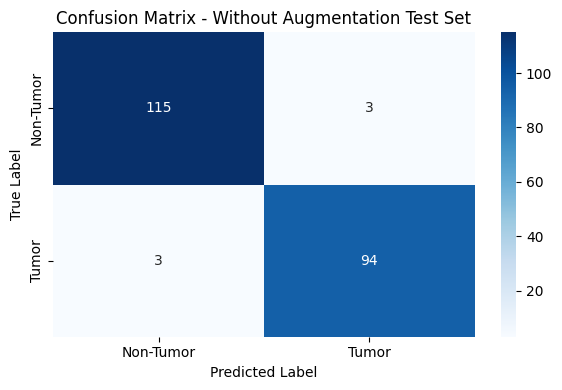

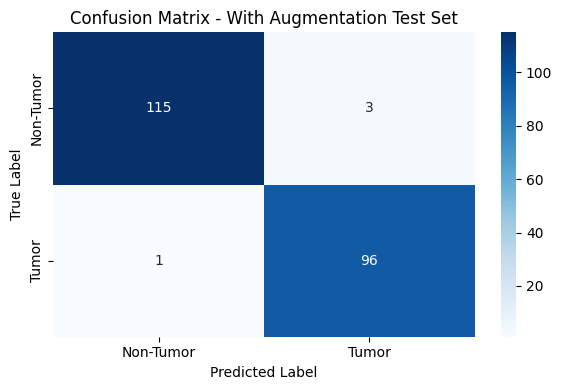

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#without augmentation
cm_no_aug = confusion_matrix(labels_no_aug, preds_no_aug)
plt.figure(figsize=(6,4))
sns.heatmap(cm_no_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Without Augmentation Test Set')
plt.tight_layout()
plt.show()

#with augmentation
cm_with_aug = confusion_matrix(labels_with_aug, preds_with_aug)
plt.figure(figsize=(6,4))
sns.heatmap(cm_with_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - With Augmentation Test Set')
plt.tight_layout()
plt.show()

In [20]:
# vit-B/16 on unseen data
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [21]:
vit_model = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
    # freeze all layers
for param in vit_model.parameters():
    param.requires_grad = False
    
    # unfreeze last 2 transformer blocks and the classification head
for name, param in vit_model.named_parameters():
    if "encoder.layers.7" in name or "encoder.layers.8" in name or "encoder.layers.9" in name or "encoder.layers.10" in name or "encoder.layers.11" in name or "heads" in name:
        param.requires_grad = True
    

vit_model.heads = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(vit_model.heads.head.in_features, 2)
    )
vit_model = vit_model.to(device)
vit_model.load_state_dict(torch.load('/home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/base_Vit_B_16/best_vit_overall.pth'))
vit_model = vit_model.to(device)
vit_model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [22]:
def evaluate_with_outputs(vit_model, loader):
    vit_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = vit_model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    return all_preds, all_labels

In [23]:
# evaluate both conditions
preds_no_aug_vit, labels_no_aug_vit = evaluate_with_outputs(vit_model, test_loader_no_aug)
preds_with_aug_vit, labels_with_aug_vit = evaluate_with_outputs(vit_model, test_loader_aug)

In [24]:
# classification reports
print("classification report without argumentation:")
print(classification_report(labels_no_aug_vit, preds_no_aug_vit, target_names=['Non-Tumor', 'Tumor']))

print("classification report with argumentation:")
print(classification_report(labels_with_aug_vit, preds_with_aug_vit, target_names=['Non-Tumor', 'Tumor']))

classification report without argumentation:
              precision    recall  f1-score   support

   Non-Tumor       0.97      0.98      0.98       118
       Tumor       0.98      0.97      0.97        97

    accuracy                           0.98       215
   macro avg       0.98      0.98      0.98       215
weighted avg       0.98      0.98      0.98       215

classification report with argumentation:
              precision    recall  f1-score   support

   Non-Tumor       0.97      0.97      0.97       118
       Tumor       0.97      0.97      0.97        97

    accuracy                           0.97       215
   macro avg       0.97      0.97      0.97       215
weighted avg       0.97      0.97      0.97       215



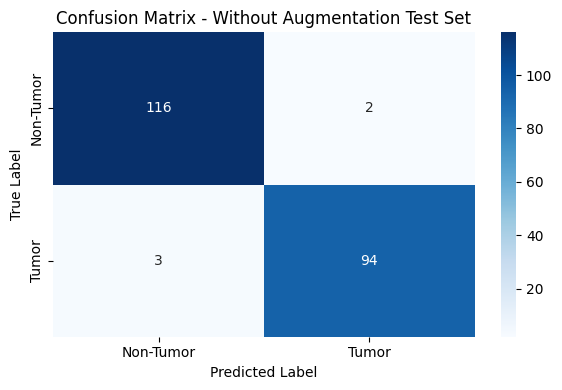

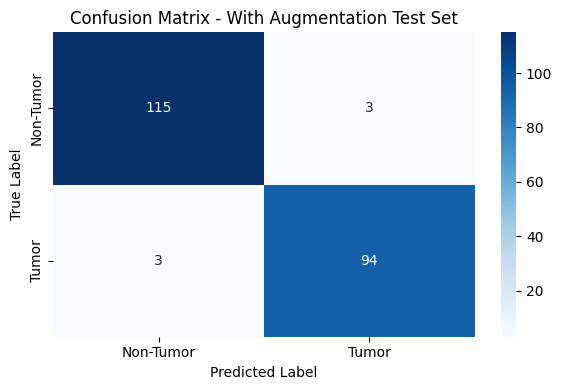

In [25]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#without augmentation
cm_no_aug_vit = confusion_matrix(labels_no_aug_vit, preds_no_aug_vit)
plt.figure(figsize=(6,4))
sns.heatmap(cm_no_aug_vit, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Without Augmentation Test Set')
plt.tight_layout()
plt.show()

#with augmentation
cm_with_aug_vit = confusion_matrix(labels_with_aug_vit, preds_with_aug_vit)
plt.figure(figsize=(6,4))
sns.heatmap(cm_with_aug_vit, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - With Augmentation Test Set')
plt.tight_layout()
plt.show()

In [8]:
# evaluate unseen data with simclr
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [9]:
class TumorDataset(Dataset):
    def __init__(self, test_ann, test_img_dir, transform=None):
        with open(test_ann, 'r') as f:
            coco_data = json.load(f)
        
        # mapping image_id to category_id
        image_id_to_label = {ann['image_id']: ann['category_id'] for ann in coco_data['annotations']}

        self.samples = []
        for img in coco_data['images']:
            file_name = img['file_name']
            img_id = img['id']
            label = image_id_to_label.get(img_id) # use get(img_id) is to look up the category_id(label) for the image using its ID

            if label is not None:
                image_path = os.path.join(test_img_dir, file_name)
                self.samples.append((image_path, label-1))
            
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
# without augmentation: just re-size and normalize
test_tranform_no_aug = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])

# with augmentation: simulate the real-world variation

test_tranform_aug = transforms.Compose([
        transforms.RandomAffine(degrees=0, shear=5, scale=(0.95,1.05)),
        transforms.RandomRotation(3),      
        transforms.RandomHorizontalFlip(p=0.5),  # reverse 50% of images
        transforms.RandomVerticalFlip(p=0.3),  # reverse 30% of images
        transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])

In [12]:
import os

In [11]:
test_no_aug = TumorDataset(
    test_ann = test_ann,
    test_img_dir = test_img_dir,
    transform=test_tranform_no_aug
)
test_with_aug = TumorDataset(
    test_ann = test_ann,
    test_img_dir = test_img_dir,
    transform=test_tranform_aug
)
test_loader_no_aug = DataLoader(test_no_aug, batch_size = 32)
test_loader_aug = DataLoader(test_with_aug, batch_size= 32)

In [12]:
# load the saved best saved model
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [13]:
encoder=models.resnet18(weights=None)
encoder.fc = nn.Identity()
encoder.load_state_dict(torch.load('/home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/base_simclr_new/best_simclr_encoder_only.pth'))
encoder = encoder.to(device)
encoder.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
class LinearClassifier(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(feature_dim, num_classes)
    def forward(self, x):
        with torch.no_grad():
            h = self.encoder(x)
        return self.classifier(h)

In [15]:
simclr_model = LinearClassifier(encoder = encoder, feature_dim=512, num_classes=2).to(device)
simclr_model .load_state_dict(torch.load('/home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/base_simclr_new/best_simclr_overall.pth'))
simclr_model  = simclr_model .to(device)
simclr_model .eval()

LinearClassifier(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [16]:
def evaluate_with_outputs(simclr_model, loader):
    simclr_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = simclr_model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    return all_preds, all_labels

In [17]:
# evaluate both conditions
preds_no_aug_simclr, labels_no_aug_simclr = evaluate_with_outputs(simclr_model, test_loader_no_aug)
preds_with_aug_simclr, labels_with_aug_simclr = evaluate_with_outputs(simclr_model, test_loader_aug)

In [18]:
# classification reports
print("classification report without argumentation:")
print(classification_report(labels_no_aug_simclr, preds_no_aug_simclr, target_names=['Non-Tumor', 'Tumor']))

print("classification report with argumentation:")
print(classification_report(labels_with_aug_simclr, preds_with_aug_simclr, target_names=['Non-Tumor', 'Tumor']))

classification report without argumentation:
              precision    recall  f1-score   support

   Non-Tumor       0.98      0.94      0.96       118
       Tumor       0.93      0.98      0.95        97

    accuracy                           0.96       215
   macro avg       0.96      0.96      0.96       215
weighted avg       0.96      0.96      0.96       215

classification report with argumentation:
              precision    recall  f1-score   support

   Non-Tumor       0.99      0.95      0.97       118
       Tumor       0.94      0.99      0.96        97

    accuracy                           0.97       215
   macro avg       0.97      0.97      0.97       215
weighted avg       0.97      0.97      0.97       215



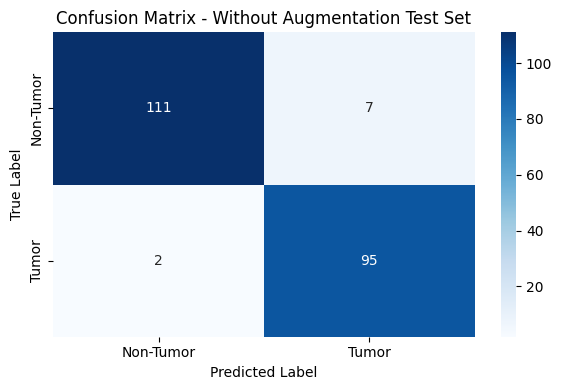

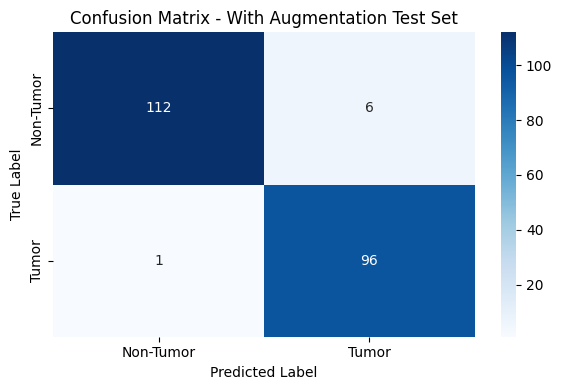

In [19]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#without augmentation
cm_no_aug_simclr = confusion_matrix(labels_no_aug_simclr, preds_no_aug_simclr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_no_aug_simclr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Without Augmentation Test Set')
plt.tight_layout()
plt.show()

#with augmentation
cm_with_aug_simclr = confusion_matrix(labels_with_aug_simclr, preds_with_aug_simclr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_with_aug_simclr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - With Augmentation Test Set')
plt.tight_layout()
plt.show()